# Training Notebook

Train Cascade Mask-RCNN

Add a couple additional things: 
- Validation Loop using loss 
- Checkpoint based off of best validation metrics
- Custom COCO Style Dataloaders

In [1]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# python libraries
import numpy as np
import os, json, random, math, time, datetime, logging
import torch, cv2
import matplotlib.pyplot as plt

%matplotlib inline

# d2 libraries
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.config import get_cfg
from detectron2.utils import comm
from detectron2.utils.logger import log_every_n_seconds
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine.hooks import EvalHook, BestCheckpointer
from detectron2.data import (
    MetadataCatalog,
    DatasetCatalog,
    build_detection_train_loader,
    build_detection_test_loader,
    get_detection_dataset_dicts,
    DatasetMapper,
)
import detectron2.data.transforms as T

# my stuff
from data_utils import read_split_file, random_split_mixed_set, register_dataset, random_split_buildings
import elevator_datasets

### Randomly Split Data

For reproducibility we seed the shuffler with the value 10

In [2]:
random_split_buildings("data/panels/ut_west_campus", (0.7, 0.1, 0.2), 10)
datasets = read_split_file("data/panels/ut_west_campus/split.txt")

### Register data splits with metadata

In [3]:
for name, im_paths in zip(["train", "val", "test"], datasets):
    DatasetCatalog.register(
        name=name, func=lambda im_paths=im_paths: register_dataset(im_paths=im_paths)
    )
    MetadataCatalog.get(name=name).thing_classes = ["label", "button"]
    MetadataCatalog.get(name=name).thing_colors = [(0, 255, 0), (0, 0, 255)]

In [4]:
trainset = DatasetCatalog.get("train")
print("trainset length: ", len(trainset))

trainset length:  125


### View Training Data Samples

Ensure that data is annotated correctly

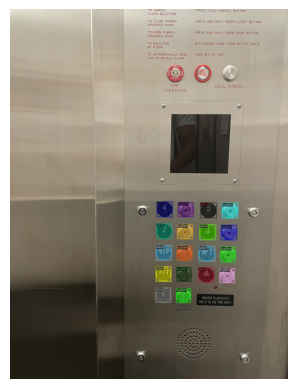

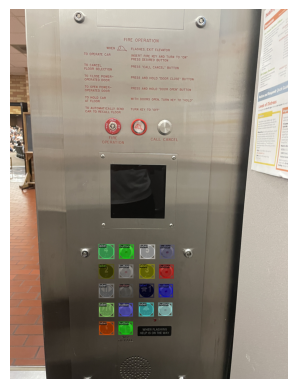

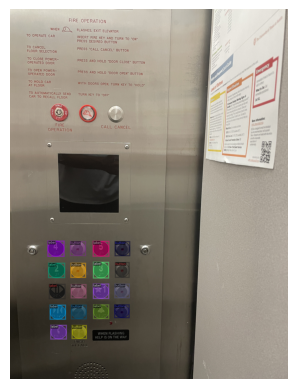

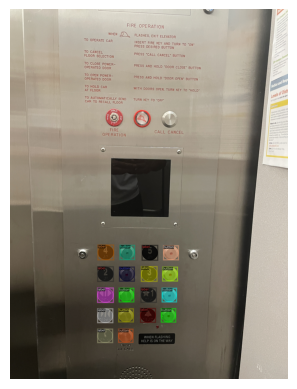

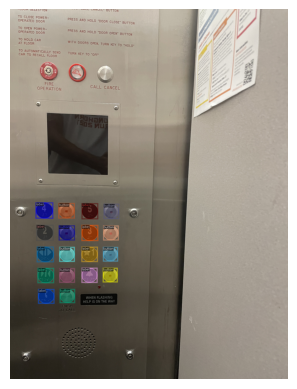

In [6]:
for d in random.sample(trainset, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=MetadataCatalog.get("train"),
        scale=1,
        instance_mode=ColorMode.IMAGE,
    )
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()

### Validation Loop using Validation Loss

In [ ]:
def validation_loop(model: torch.nn, dataloader: torch.utils.data.DataLoader) -> dict:
    """
    Validate model on the given dataloader. Put model in training mode to output loss
    dict but do not backpropogate gradients. Largely adapted from train_loop.py and
    inference_on_dataset

    Args:
        model (torch.nn): model to validate
        dataloader (torch.utils.data.DataLoader): validation dataloader set to training
            mode

    Returns:
        dict: {"validation_loss": val_loss}
    """
    model.train()
    num_batches = len(dataloader)
    num_warmup = min(5, num_batches - 1)
    start_time = time.perf_counter()
    total_compute_time = 0
    losses = []
    for idx, data in enumerate(dataloader):
        if idx == num_warmup:
            start_time = time.perf_counter()
            total_compute_time = 0
        start_compute_time = time.perf_counter()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        total_compute_time += time.perf_counter() - start_compute_time
        iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
        seconds_per_img = total_compute_time / iters_after_start
        if idx >= num_warmup * 2 or seconds_per_img > 5:
            total_seconds_per_img = (
                time.perf_counter() - start_time
            ) / iters_after_start
            eta = datetime.timedelta(
                seconds=int(total_seconds_per_img) * (num_batches - idx - 1)
            )
            log_every_n_seconds(
                logging.INFO,
                "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                    idx + 1, num_batches, seconds_per_img, str(eta)
                ),
                n=5,
            )

        batch_loss_dict = model(data)
        batch_loss_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in batch_loss_dict.items()
        }
        total_batch_loss = sum(loss for loss in batch_loss_dict.values())
        losses.append(total_batch_loss)
    val_loss = np.mean(losses)
    comm.synchronize()
    log_every_n_seconds(logging.INFO, f"VALIDATION_LOSS: {val_loss:.5f}")
    return {"validation_loss": val_loss}

### Define a Custom Trainer

Add custom hooks and dataloader

In [ ]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(
            dataset=get_detection_dataset_dicts(
                cfg.DATASETS.TRAIN[0], filter_empty=False
            ),
            mapper=DatasetMapper(
                is_train=True,
                augmentations=[
                    T.ResizeScale(
                        min_scale=0.1,
                        max_scale=2.0,
                        target_height=1024,
                        target_width=1024,
                    ),
                    T.FixedSizeCrop(crop_size=(1024, 1024), pad=False),
                ],
                image_format="RGB",
                use_instance_mask=True,
                recompute_boxes=True,
            ),
            total_batch_size=cfg.SOLVER.IMS_PER_BATCH,
            num_workers=cfg.DATALOADER.NUM_WORKERS,
        )

    @classmethod
    def build_validation_loader(cls, cfg):
        return build_detection_test_loader(
            dataset=get_detection_dataset_dicts(
                cfg.DATASETS.VAL[0], filter_empty=False
            ),
            mapper=DatasetMapper(
                is_train=True,
                augmentations=[
                    T.ResizeShortestEdge(short_edge_length=1024, max_size=1024)
                ],
                image_format="BGR",
                use_instance_mask=True,
            ),
        )

    def build_hooks(self) -> list:
        """
        Overwrite the evaluation loop and checkpoint using best validation loss

        Returns:
            list: list of hooks
        """
        hooks = super().build_hooks()
        # remove existing EvalHook
        if comm.is_main_process():
            del hooks[-2]
            del hooks[-2]
        else:
            del hooks[-1]
        hooks.extend(
            [
                EvalHook(
                    eval_period=self.cfg.TEST.EVAL_PERIOD,
                    eval_function=lambda: validation_loop(
                        self.model,
                        self.build_validation_loader(self.cfg),
                    ),
                    eval_after_train=True,
                ),
                BestCheckpointer(
                    eval_period=self.cfg.TEST.EVAL_PERIOD,
                    checkpointer=self.checkpointer,
                    val_metric="validation_loss",
                    mode="min",
                ),
            ]
        )
        return hooks

### Define Config for Building Model

In [ ]:
mask_rcnn_res50 = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
mask_rcnn_res101 = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
cascade_mask_rcnn_res50 = "Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"

base_cfg = mask_rcnn_res101

cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file(base_cfg)
)

# start from pretrained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(base_cfg)

# assign datasets and adjust ROI HEADS to match num classes
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.VAL = ("val",)
cfg.DATASETS.TEST = ("test",)
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

# Calculate training logic
epochs = 100
batch_size = 2
eval_period = 2
iters_per_epoch = math.ceil(len(trainset) / batch_size)

cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.MAX_ITER = iters_per_epoch * epochs
cfg.TEST.EVAL_PERIOD = iters_per_epoch * eval_period
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.STEPS = [int(0.7 * cfg.SOLVER.MAX_ITER), int(0.8 * cfg.SOLVER.MAX_ITER)]
cfg.SOLVER.WARMUP_ITERS = int(0.067 * cfg.SOLVER.MAX_ITER)

# SAVE DIR
cfg.OUTPUT_DIR = "./output"

### Train Configured Model

Use modified DefaultTrainer

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

### Plot Training and Validation Curves

In [ ]:
def load_json_arr(json_path):
    train, val = [], []
    with open(json_path, "r") as f:
        for line in f:
            l = json.loads(line)
            if "validation_loss" in l:
                val.append(l)
            elif "total_loss" in l:
                train.append(l)
    return train, val

In [ ]:
train_metrics, val_metrics = load_json_arr("new_models/mrcnn101/metrics.json")
train_metrics = train_metrics[2:]

In [ ]:
train_iters = [x["iteration"] for x in train_metrics]
train_loss = [x["total_loss"] for x in train_metrics]

val_iters = [x["iteration"] for x in val_metrics]
val_loss = [x["validation_loss"] for x in val_metrics]

In [ ]:
plt.plot(train_iters, train_loss)
plt.plot(val_iters, val_loss)
plt.xlabel("iters")
plt.ylabel("loss")
plt.title("train/val loss")
plt.legend(["training loss", "validation loss"], loc="upper right")
plt.show()

### Evalatuate Model on Held Out Testset

Using Default Predictor with Threshold of 0.7

In [ ]:
cfg.MODEL.WEIGHTS = "new_models/mrcnn101/model_best.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator(
    dataset_name="test",
    output_dir=os.path.join("new_models/mrcnn101/inference"),
    allow_cached_coco=False,
    use_fast_impl=False,
)
testloader = build_detection_test_loader(cfg, "test")
print(inference_on_dataset(predictor.model, testloader, evaluator))

### View Output of Model on Test Images

In [ ]:
testset = get_detection_dataset_dicts("test", filter_empty=False)
for d in random.sample(testset, 5):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(
        img[:, :, ::-1],
        metadata=MetadataCatalog.get("test"),
        scale=1.0,
        instance_mode=ColorMode.SEGMENTATION,
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()